## 2.2 Example 2: One Dimensional Heat Diffusion in an Iron Rod

**The scripts referenced in this section are: example02.py**

Our second example is of a cold iron bar at a constant temperature of $T_{ref}=20^{\circ} C$, see Figure 2.5. The bar is perfectly insulated on all sides with a heating element at one end keeping the temperature at a constant level $T_0=100^{\circ} C$. As heat is applied energy will disperse along the bar via conduction. With time the bar will reach a constant temperature equivalent to that of the heat source...

<br>
 <figure>
  <img src="figures/onedheatdiff002.svg">
  <figcaption>
    <center>
      Figure 2.5: Example 2: One dimensional model of an Iron bar.
    </center>
  </figcaption>
</figure>
<br>

This problem is very similar to the example of temperature diffusion in granite blocks presented in the previous Section 2.1. Thus, it is possible to modify the script we have already developed for the granite blocks to suit
the iron bar problem. The obvious differences between the two problems are the dimensions of the
domain and different materials involved. This will change the time scale of the
model from years to hours. The new settings are:

In [7]:
from esys.escript import * # This imports everything from the escript library
from esys.escript.unitsSI import * 
from esys.escript.linearPDEs import LinearPDE # This defines LinearPDE as LinearPDE
from esys.finley import Rectangle
import matplotlib
import pylab as pl #Plotting package.
import numpy as np #Array package.
import os, sys #This package is necessary to handle saving our data.

##Domain related.
mx = 1*m #meters - model length
my = .1*m #meters - model width
ndx = 100 # mesh steps in x direction
ndy = 1 # mesh steps in y direction - one dimension means one element
##PDE related
rho = 7874. *kg/m**3 #kg/mˆ{3} density of iron
cp = 449.*J/(kg*K) # J/Kg.K thermal capacity
rhocp = rho*cp
kappa = 80.*W/m/K # watts/m.Kthermal conductivity
qH = 0 * J/(sec*m**3) # J/(sec.mˆ{3}) no heat source
Tref = 20 * Celsius # base temperature of the rod
T0 = 100 * Celsius # temperature at heating element
##Parameters
t=0 * day  # our start time, usually zero
tend= 0.5 *day  # - time to end simulation
outputs = 200 # number of time steps required.
h=(tend-t)/outputs #size of time step
#user warning statement
print("Expected Number of time outputs is: ", (tend-t)/h)
i=0 #loop counter
##Save path 
save_path= os.path.join("data","example02")
#ensure the dir exists
mkDir(save_path, os.path.join(save_path,"tempT"))
##Domain construction
rod = Rectangle(l0=mx,l1=my,n0=ndx, n1=ndy)
x=Solution(rod).getX()

Expected Number of time outputs is:  200.0


We also need to alter the initial value for the temperature. Now we need to set the temperature to $T_{0}$ at the left end of the rod where we have $x_{0}=0$ and $T_{ref}$ elsewhere. Instead of `whereNegative` function we now use `whereZero` which returns the value one for those sample points where the argument (almost) equals zero and the value zero elsewhere. The initial temperature is set to:

In [8]:
# ... set initial temperature ....
T= T0*whereZero(x[0])+Tref*(1-whereZero(x[0]))

### 2.2.1 Dirichlet Boundary Conditions

In the iron rod model we want to keep the initial temperature $T_0$ on the left side of the domain constant with time.  This implies that when we solve the PDE Equation (2.5), the solution must have the value $T_0$ on the left hand side of the domain. As mentioned already in Section 2.1.3 where we discussed boundary conditions, this kind of scenario can be expressed using a `Dirichlet boundary condition`. Some people also use the term `constraint` for the PDE. 

To define a Dirichlet boundary condition we need to specify where to apply the condition and determine what value the solution should have at these locations. In *escript* we use $q$ and $r$ to define the Dirichlet boundary conditions for a PDE. The solution $u$ of the PDE is set to $r$ for all sample points where $q$ has a positive value. Mathematically this is expressed in the form:

\begin{equation}
  u(x) = r(x) \mbox{ for any } x \mbox{ with } q(x) > 0
\end{equation} 

In the case of the iron rod we can set the following to prescribe the value $T_{0}$ for the temperature at the left end of the rod where $x_{0}=0$.

In [9]:
q=whereZero(x[0])
r=T0

Here we use the `whereZero` function again which we have already used to set the initial value. Notice that $r$ is set to the constant value $T_{0}$ for all sample points. In fact, values of $r$ are used only where $q$ is positive. Where $q$ is non-positive, $r$ may have any value as these values are not used by the PDE solver. 

To set the Dirichlet boundary conditions for the PDE to be solved in each time step we need to add some statements:

In [10]:
mypde=LinearPDE(rod)
A=zeros((2,2))
A[0,0]=kappa
q=whereZero(x[0])
mypde.setValue(A=A, D=rhocp/h, q=q, r=T0)

It is important to remark here that if a Dirichlet boundary condition is prescribed on the same location as any Neumann boundary condition, the Neumann boundary condition will be **overwritten**. This applies to Neumann boundary conditions that *escript* sets by default and those defined by the user.

Now we can run the following code to simulate the hear diffusion process and plot some results.

Simulation started, please wait...


<IPython.core.display.Javascript object>


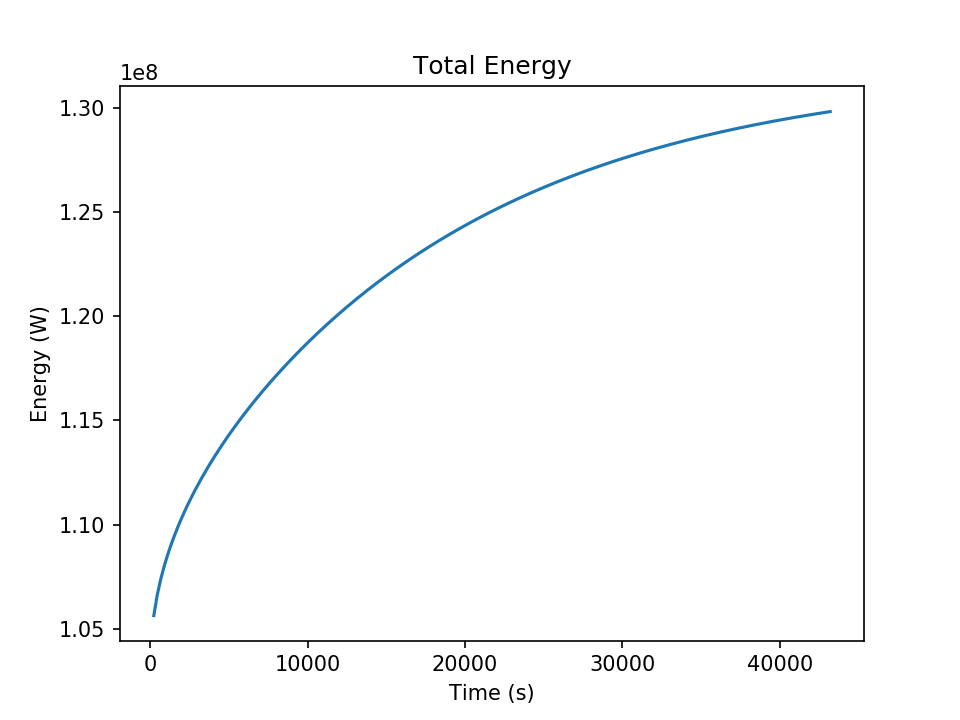

Simulation completed


In [11]:
# makes a nice plotting window
%matplotlib notebook

# ... open a collector for the time marks and corresponding total energy
t_list=[]
E_list=[]
# ... convert solution points for plotting
plx = x.toListOfTuples() 
plx = np.array(plx) #convert tuple to numpy array
plx = plx[:,0] #extract x locations
########################################################START ITERATION
print("Simulation started, please wait...")
t=0 * day
while t<tend:
    i+=1
    t+=h
    mypde.setValue(Y=qH+rhocp/h*T)
    T=mypde.getSolution()
    totE=integrate(rhocp*T)
    #print("time step %s at t=%e minutes completed. total energy = %e."%(i,t/minute,totE))
    t_list.append(t)
    E_list.append(totE)

    #establish figure 1 for temperature vs x plots
    tempT = T.toListOfTuples()
    #pl.figure(1) #current figure
    pl.plot(plx,tempT) #plot solution
    # add title
    pl.axis([0,mx,Tref*.9,T0*1.1])
    pl.ylabel('Temperature (K)')
    pl.xlabel("Length (m)")
    pl.title("Temperature across rod at time %e hours"%(t/hour))
    #save figure to file
    pl.savefig(os.path.join(save_path,"tempT", "rodpyplot%03d.png"%i))
    pl.clf() #clear figure

# plot the total energy over time:
#pl.figure(2)
pl.plot(t_list,E_list)
pl.title("Total Energy")
pl.ylabel('Energy (W)')
pl.xlabel('Time (s)')
# pl.axis([0,max(t_list),0,max(E_list)*1.1])
pl.savefig(os.path.join(save_path,"totE.png"))
pl.show()
print("Simulation completed.")

The total energy over time is shown in above figure. As heat is transferred into the rod by the heater the total energy is growing over time but reaches a plateau when the temperature is constant in the rod, see Figure (2.8). You will notice that the time scale of this model is several order of magnitudes faster than for the granite rock problem due to the different length scale and material parameters. In practice it can take a few model runs before the right time scale has been chosen. An estimate of the time scale for a diffusion problem is given by the formula $\frac{\rho c_{p} L_{0}^2}{4 \kappa}$, see [reference](http://en.wikipedia.org/wiki/Fick\%27s_laws_of_diffusion).

<br>
 <figure>
  <img src="figures/rodpyplot001.png" width="400">
 </figure>

 <figure>
  <img src="figures/rodpyplot050.png" width="400">
 </figure>

 <figure>
  <img src="figures/rodpyplot200.png" width="400">
 </figure>

 <figure>
  <img src="figures/rodpyplot400.png" width="400">
  <figcaption>
    <center>
      Figure 2.8: Example 2: Temperature ($T$) distribution in the iron rod at time steps
$1$, $50$ and $200$.
    </center>
  </figcaption>
 </figure>
<br>